In [1]:
from csmarapi.CsmarService import CsmarService
csmar = CsmarService()
from csmarapi.ReportUtil import ReportUtil
csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

Wed 05 Oct 2022 13:27:52 CsmarService.py INFO User login succeed


In [1]:
import re
from functools import reduce
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dask import dataframe as ddf
from IPython.display import display

# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def round_(data : float):
    return str(round(data, 4)*100) + '%'

In [3]:
maininfo = pd.read_csv('data/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
maininfo['InceptionDate'] = maininfo.InceptionDate.dt.to_period('M')


unitclassinfo = pd.read_csv('data/FUND_UnitClassInfo.csv', parse_dates=['ListingDate', 'InceptionDate'])
unitclassinfo['InceptionDate'] = unitclassinfo.InceptionDate.dt.to_period('M')
unitclassinfo['MasterFundCode'] = unitclassinfo.MasterFundCode.astype('Int64')


allocation = pd.read_csv('data/Fund_Allocation.csv', parse_dates=['EndDate'])
allocation['EndDate'] = allocation.EndDate.dt.to_period('M')


fees = ddf.read_csv('data/管理费率/*', dtype={'Symbol': 'object', 'ProportionOfFee': 'object'}, parse_dates=['DeclareDate']).compute()
fees['DeclareDate'] = fees.DeclareDate.dt.to_period('M')
fees['Symbol'] = fees.Symbol.astype(int)
fees = fees[np.logical_and(fees.NameOfFee != '最低赎回份额', fees.NameOfFee != '最低申购份额')]


fund_dividend = pd.read_csv('data/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
fund_dividend['PrimaryExDividendDate'] = fund_dividend.PrimaryExDividendDate.dt.to_period('M')
fund_dividend['SecondaryExDividendDate'] = fund_dividend.SecondaryExDividendDate.dt.to_period('M')


nav_month = pd.read_csv('data/Fund_NAV_Month.csv', parse_dates=['TradingDate'])
nav_month['TradingDate'] = nav_month.TradingDate.dt.to_period('M')


resolution = pd.read_csv('data/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['DeclareDate'] = resolution.DeclareDate.dt.to_period('M')


share_info = pd.read_csv('data/Fund_ShareChange.csv', parse_dates=['EndDate'])
share_info['EndDate'] = share_info.EndDate.dt.to_period('M')

### **#data-insight**

 #**1. `Symbol`, `MasterFundCode`, `FundID`?**

`Symbol` is queryable in Win.d

`Symbol` translates as  `前端代码(Win.d)/基金代码(CSMAR)/前端代码(CSMAR)`

`Symbol == 11228` means `011228.OF`

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

`Symbol` may map more than one fund name, only the latest one is ongoing, **use the latest one** (checked `Win.d`)

`MasterFundCode` is the first `Symbol` in ***a collection of funds***

***a collection of funds, e.g.***

*西部利得量化成长A, 000006.OF, 2019-03-19*

*西部利得量化成长C, 011228.OF, 2021-01-13*

*or*

*中海可转债A, 000003.OF, 2013-03-20*

*中海可转债C, 000004.OF, 2013-03-20*

|            |                    | A      | C       |                          |
| ---------- | ------------------ | ------ | ------- | ------------------------ |
| 运作方式   | operation          | same   | same    |                          |
| 管理费     | management fee     | same   | same    |                          |
| 认购费     | purchase fee       | √     |         |                          |
| 销售服务费 | sales service fees |        | √      | charge from net value |
| 赎回费     | redemption fee    | bigger | smaller |                          |

*≈60%* `MasterFundCode` has multiple symbols

`MasterFundCode` can be inferred from `Symbol`

`FundID` is in bijection with `MasterFundCode`

`FundID` is not queryable in Win.d --> *`FundID` used by CSMAR only?*

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

**use `Symbol`**

 #**2. `InceptionDate`, `ListingDate`?**
 
`InceptionDate`: 成立日期

`ListingDate`: 上市日期

*<10%* `ListingDate` is available

*=100%* `InceptionDate` is available

*≈85%* collection of funds has the same `InceptionDate`

**use `InceptionDate`**

 #**3. `Equity`, `StockAmount`? `allocation` data quality**

`Equity` is ≈60% the same as `StockAmount`

when `StockAmount` is not available, ≈100% `Equity` is available

when `Equity` is not available, ≈0% `StockAmount` is available

**use `Equity`**

but, ≈30% `Equity` is not available while `TotalAsset` is available

固定收益类投资

in the last report period, ≈30% `Equity` is not available while `TotalAsset` is available

 #**4. `unitclassinfo`, `nav_month`**

检查0

wrong data, in `nav_month`, ≈1.5% values are 0

**`nav_month`, `unitclassinfo` both have unique symbols in itself**

 #**5. `Fund_Resolution`, `Fund_FundDividend`**

≈1% fund have multiple dividend payouts in one month, `sum` them

≈1% fund have multiple divisions in one month, `cumulative product` them

 #**6. `Fund_FeesChange`**

≈0.01% data are duplicated

compared with `Win.d`, **we should keep the first one**

## **I. Data Preprocessing**

### **1. align MasterFundCode, Symbol**

#### i. check: FUND_MainInfo

基金概况 — 基金主体信息表

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

In [4]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2, specs=specs)
fig.add_trace(go.Pie(labels=maininfo.Category.value_counts().index, values=maininfo.Category.value_counts().values), 1, 1)

# IsETF [是否ETF] - 1=是；2=否
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2], ['ETF', '非ETF'])\
    .IsETF.value_counts().index, values=maininfo.IsETF.value_counts().values), 1, 2)

# IsQDII [是否QDII] - 1=是；2=否
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2], ['QDII', '非QDII'])\
    .IsQDII.value_counts().index, values=maininfo.IsQDII.value_counts().values), 2, 1)
    
# IsActiveOrPassive [主动标识] - 1=主动；2=被动
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2, np.nan], ['1主动', '2被动', '空'])\
    .IsActiveOrPassive.value_counts().index, values=maininfo.replace([1, 2, np.nan], ['1主动', '2被动', '空']).IsActiveOrPassive.value_counts().values), 2, 2)
fig.update_layout(width=800, height=800)


In [5]:
(maininfo.groupby('MasterFundCode').apply(lambda per_MasterFundCode: len(per_MasterFundCode.FundID.unique())) != 1).any()

False

In [6]:
(maininfo.groupby('FundID').apply(lambda per_FundID: len(per_FundID.MasterFundCode.unique())) != 1).any()

False

`FundID` is in bijection with `MasterFundCode`, they make no difference in later research

Use `MasterFundCode` instead of `FundID`, because `MasterFundCode` is covered in most tables


#### ii. check: FUND_UnitClassInfo

基金概况 — 基金份额类别信息表

**erratum**

*problem*: use `Symbol` to merge `maininfo`, found ≈3% duplicated `Symbol`

*reason*: fund changed its name

*solve*: keep the latest `Symbol`

In [7]:
unitclassinfo[unitclassinfo.Symbol.duplicated(keep=False)]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
28,37,37,广发理财7天债券A,2013-06,NaT
29,37,37,广发景宁纯债A,2020-04,NaT
85,104,104,华宸未来信用增利,2013-08,NaT
86,104,104,华宸未来稳健添利债券A,2018-08,NaT
114,134,134,理财28日盈A,2017-05,NaT
...,...,...,...,...,...
18661,660016,660016,农银汇理金聚高等级债券,2020-06,NaT
18680,673100,673100,西部利得久安回报混合,2017-03,NaT
18681,673100,673100,西部利得沪深300指数增强A,2018-12,NaT
18729,690012,690012,民生加银家盈理财7天债券A,2013-02,NaT


<img src="attachment/37_.png" alt="drawing" width="200"/> <img src="attachment/37.jpg" alt="drawing" width="800"/>
<img src="attachment/104_.png" alt="drawing" width="200"/> <img src="attachment/104.png" alt="drawing" width="800"/>

In [8]:
round_(len(unitclassinfo[unitclassinfo.Symbol.duplicated(keep=False)]) / len(unitclassinfo)) + ' funds changed name'

'2.5100000000000002% funds changed name'

In [9]:
unitclassinfo_ = unitclassinfo.drop_duplicates(subset=['Symbol'], keep='last')

**erratum**

*problem*: ≈0.5% *NA* `MasterFundCode`

*reason*: wrong data

*solve*: delete all *NA* `MasterFundCode`

In [10]:
unitclassinfo_[pd.isnull(unitclassinfo_.MasterFundCode)]
# `unitclassinfo_.MasterFundCode` is `Int64`, display <NA> instead of NaN

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
927,<NA>,1041,南方理财60天债券E,2015-03,NaT
1715,<NA>,1888,中欧盛世成长混合(LOF)E,2015-10,NaT
2104,<NA>,2294,博时新机遇混合C,2016-01,NaT
2221,<NA>,2418,汇添富优选回报混合C,2016-02,NaT
2387,<NA>,2591,中欧信用增利债券E,2016-04,NaT
...,...,...,...,...,...
16589,<NA>,163008,长信利鑫债券(LOF)A,2017-01,NaT
16705,<NA>,164822,工银政府债纯债债券C,2017-01,NaT
16828,<NA>,167502,宝利A,2013-07,NaT
16966,<NA>,202308,南方收益宝货币B,2015-07,NaT


<img src="attachment/1041.png" alt="drawing" width="400"/> <img src="attachment/1041_.png" alt="drawing" width="400"/>

<img src="attachment/1888.png" alt="drawing" width="400"/> <img src="attachment/1888_.png" alt="drawing" width="400"/>

In [11]:
unitclassinfo_[unitclassinfo_.Symbol == 1041]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
927,<NA>,1041,南方理财60天债券E,2015-03,NaT


In [12]:
unitclassinfo_[unitclassinfo_.Symbol == 1888]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
1715,<NA>,1888,中欧盛世成长混合(LOF)E,2015-10,NaT


In [13]:
round_(pd.isnull(unitclassinfo_.MasterFundCode).sum() / len(unitclassinfo)) + ' error'

'0.53% error'

In [14]:
unitclassinfo_ = unitclassinfo_[pd.notnull(unitclassinfo_.MasterFundCode)]
unitclassinfo__ = unitclassinfo_.set_index(['MasterFundCode', 'Symbol'])
unitclassinfo__

ShortName InceptionDate ListingDate
MasterFundCode Symbol                                            
3              3                 中海可转债A       2013-03         NaT
               4                 中海可转债C       2013-03         NaT
5              5             嘉实增强信用定期债券       2013-03         NaT
6              6            西部利得量化成长混合A       2019-03         NaT
7              7                鹏华国企债债券       2013-03         NaT
...                                 ...           ...         ...
970191         970191         申万宏源天天增货币       2022-08         NaT
920187         970193    中金丰裕稳健一年持有混合型C       2022-07         NaT
970194         970194  兴证资管金麒麟3个月(FOF)A       2022-09         NaT
               970195  兴证资管金麒麟3个月(FOF)C       2022-09         NaT
980003         980003    太平洋证券六个月滚动持有债券       2020-04         NaT

[18915 rows x 3 columns]

In [15]:
f'{round_(pd.notnull(unitclassinfo__.ListingDate).sum() / len(unitclassinfo__))} of `ListingDate` available'

'8.61% of `ListingDate` available'

In [16]:
f'{round_(pd.notnull(unitclassinfo__.InceptionDate).sum() / len(unitclassinfo__))} of `InceptionDate` available'

'100.0% of `InceptionDate` available'

In [17]:
f'{round_(len(unitclassinfo__.index.levels[0]) / len(unitclassinfo__.index.levels[1]))} `MasterFundCode` have multiple symbols'

'60.150000000000006% `MasterFundCode` have multiple symbols'

In [18]:
symbol_date_identical = unitclassinfo__.groupby(level=0).apply(lambda _: True if len(_.InceptionDate.unique()) == 1 else False)
f'{round_(symbol_date_identical.sum() / len(symbol_date_identical))} `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

'85.39999999999999% `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

**erratum**

*problem*: ≈0.22% `unitclassinfo` has less unique `MasterFundCode`, while `maininfo` has all `MasterFundCode`

*reason*:

- fund changed its name

- lack of data

*solve*: use `MasterFundCode` & `Symbol` in `unitclassinfo`

In [19]:
np.setdiff1d(unitclassinfo_.MasterFundCode, maininfo.MasterFundCode.unique())

array([], dtype=object)

In [20]:
np.setdiff1d(maininfo.MasterFundCode.unique(), unitclassinfo_.MasterFundCode)

array([   500,    622,    791,    813,    909,  10656,  12570,  13363,
        15393,  15514,  15838,  15948,  16005,  16250,  16396,  16454,
        16513,  16517,  16566,  16596,  16609, 180102, 240021, 550017,
       970186], dtype=int64)

In [21]:
# e.g. fund changed its name
maininfo[maininfo.MasterFundCode == 500]

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
293,10131316,500,华富恒富分级债券型证券投资基金,2014-03,债券型基金,2,2,NaN


In [22]:
# e.g. fund changed its name
# locate `MasterFundCode == 500`, find `Symbol == 501` or `Symbol == 502`
unitclassinfo[unitclassinfo.MasterFundCode == 500]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
425,500,501,华富恒富分级债券A,2014-03,NaT
427,500,502,华富恒富分级债券B,2014-03,NaT


In [23]:
# e.g. fund changed its name
# `Symbol == 501` or `Symbol == 502` in original data
# the latest `MasterFundCode` change to 502, instead of 500
# but they have same `Symbol`
unitclassinfo[unitclassinfo.Symbol == 501]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
425,500,501,华富恒富分级债券A,2014-03,NaT
426,502,501,华富恒富18个月定开债C,2017-11,NaT


In [24]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.Symbol == 501]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
426,502,501,华富恒富18个月定开债C,2017-11,NaT


In [25]:
# e.g. fund changed its name
unitclassinfo[unitclassinfo.Symbol == 502]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
427,500,502,华富恒富分级债券B,2014-03,NaT
428,502,502,华富恒富18个月定开债A,2017-11,NaT


In [26]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.Symbol == 502]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
428,502,502,华富恒富18个月定开债A,2017-11,NaT


In [27]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.MasterFundCode == 500]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate


In [28]:
# 500, 622, 791, 813, 909 are because of renaming
# others are lack of data

# e.g. lack of data
unitclassinfo[unitclassinfo.MasterFundCode == 10656]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate


In [29]:
# `MasterFundCode` included in `maininfo` but not in `unitclassinfo`
# some born NA, some changed name

f'{round_(len(np.setdiff1d(maininfo.MasterFundCode.unique(), unitclassinfo_.MasterFundCode)) / len(maininfo.MasterFundCode.unique()))} \
MasterFundCode will be dropped'

'0.22% MasterFundCode will be dropped'

#### iii. concatenate

**Q**: We use `Symbol`, and `Symbol` is duplicated, why drop `MasterFundCode` here?

**A**: `MasterFundCode` is the proper `key` both table have in common. If we drop with `key` of `Symbol`, program does not know what to do with `maininfo`

In [30]:
selected_columns = ['FundID', 'MasterFundCode', 'FullName', 'Symbol', 'InceptionDate_y', 'Category', 'IsETF', 'IsQDII', 'IsActiveOrPassive']
maininfo_ = pd.merge(maininfo, unitclassinfo_, how='inner' ,on='MasterFundCode')[selected_columns].drop_duplicates(subset='Symbol').reset_index(drop=True)
maininfo_['InceptionDate'] = maininfo_.InceptionDate_y
maininfo_ = maininfo_.drop('InceptionDate_y', axis=1)
maininfo_

,FundID,MasterFundCode,FullName,Symbol,Category,IsETF,IsQDII,IsActiveOrPassive,InceptionDate
0,10110606,3,中海可转换债券债券型证券投资基金,3,债券型基金,2,2,NaN,2013-03
1,10110606,3,中海可转换债券债券型证券投资基金,4,债券型基金,2,2,NaN,2013-03
2,10110338,5,嘉实增强信用定期开放债券型证券投资基金,5,债券型基金,2,2,NaN,2013-03
3,10445836,6,西部利得量化成长混合型发起式证券投资基金,6,混合型基金,2,2,1.0,2019-03
4,10445836,6,西部利得量化成长混合型发起式证券投资基金,11228,混合型基金,2,2,1.0,2021-01
...,...,...,...,...,...,...,...,...,...
18910,10596615,970187,申万宏源天添利货币型集合资产管理计划,970187,货币型基金,2,2,NaN,2022-08
18911,10596605,970191,申万宏源天天增货币型集合资产管理计划,970191,货币型基金,2,2,NaN,2022-08
18912,10598181,970194,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,970194,FOF,2,2,1.0,2022-09
18913,10598181,970194,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,970195,FOF,2,2,1.0,2022-09


### **2. filter data**

#### i. first 4 : static filtering

（1）基金类别必须为“股票型基金”或“混合型基金”；

（2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空；

In [31]:
filter_1 = np.logical_or(maininfo_.Category == '股票型基金', maininfo_.Category == '混合型基金')
filter_2 = maininfo_.IsETF == 2
filter_3 = maininfo_.IsQDII == 2
filter_4 = maininfo_.IsActiveOrPassive != 2

filters = [(1, filter_1), (2, filter_2), (3, filter_3), (4, filter_4)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(maininfo_)

# proportional data left

array([0.61908538, 0.9554322 , 0.97383029, 0.83246101])

In [32]:
def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(maininfo_)} to {previous[1].sum()}, ' + round_(1 - previous[1].sum() / len(maininfo_)) + ' symbols dropped')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}, ' + round_(1 - temp.sum() / previous[1].sum()) + ' symbols dropped')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}, ' + round_(1 - temp.sum() / previous.sum()) + ' symbols dropped')
        return temp


filters_ = reduce(func, filters)

filter 1: 18915 to 11710, 38.09% symbols dropped
filter 2: 11710 to 10969, 6.329999999999999% symbols dropped
filter 3: 10969 to 10654, 2.87% symbols dropped
filter 4: 10654 to 8786, 17.53% symbols dropped


In [33]:
maininfo__ = maininfo_[filters_]
maininfo__.set_index('Symbol').sort_index()

,FundID,MasterFundCode,FullName,Category,IsETF,IsQDII,IsActiveOrPassive,InceptionDate
Symbol,,,,,,,,
6,10445836,6,西部利得量化成长混合型发起式证券投资基金,混合型基金,2,2,1.0,2019-03
11,107794,11,华夏大盘精选证券投资基金,混合型基金,2,2,1.0,2004-08
17,10110640,17,财通可持续发展主题混合型证券投资基金,混合型基金,2,2,1.0,2013-03
20,10110534,20,景顺长城品质投资混合型证券投资基金,混合型基金,2,2,1.0,2013-03
21,10102822,21,华夏优势增长混合型证券投资基金,混合型基金,2,2,1.0,2006-11
...,...,...,...,...,...,...,...,...
970120,10578152,970120,兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划,混合型基金,2,2,1.0,2021-12
970121,10578152,970120,兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划,混合型基金,2,2,1.0,2021-12
970184,10596614,880006,招商资管核心优势混合型集合资产管理计划,混合型基金,2,2,1.0,2022-08


#### ii. use filtered data (first 4) to create big table

big table: from `Symbol` indexed only to `Symbol-Month` multiIndex

In [34]:
indexes = pd.MultiIndex.from_product([maininfo__.Symbol.sort_values().values, pd.date_range('2002-1', '2022-10', freq='Q')])
temp_symbols = indexes.get_level_values(0)
temp_EndDate = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['Symbol'] = temp_symbols
main_data['EndDate'] = temp_EndDate.to_period('M')
main_data = pd.merge(main_data, maininfo__[['Symbol', 'InceptionDate', 'MasterFundCode', 'Category', 'FullName']], on='Symbol')
main_data = main_data[main_data.EndDate >= main_data.InceptionDate].reset_index(drop=True)
main_data.set_index(['Symbol', 'EndDate'])

InceptionDate  MasterFundCode Category  \
Symbol EndDate                                          
6      2019-03       2019-03               6    混合型基金   
       2019-06       2019-03               6    混合型基金   
       2019-09       2019-03               6    混合型基金   
       2019-12       2019-03               6    混合型基金   
       2020-03       2019-03               6    混合型基金   
...                      ...             ...      ...   
970121 2022-06       2021-12          970120    混合型基金   
       2022-09       2021-12          970120    混合型基金   
970184 2022-09       2022-08          880006    混合型基金   
970185 2022-09       2022-08          880006    混合型基金   
970193 2022-09       2022-07          920187    混合型基金   

                                   FullName  
Symbol EndDate                               
6      2019-03         西部利得量化成长混合型发起式证券投资基金  
       2019-06         西部利得量化成长混合型发起式证券投资基金  
       2019-09         西部利得量化成长混合型发起式证券投资基金  
       2019-12         西部利得量化成长混合型发起式证券投资基金  
       2020-03         西部利得量化成长混合型发起式证券投资基金  
...                                     ...  
970121 2022-06  兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划  
       2022-09  兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划  
970184 2022-09          招商资管核心优势混合型集合资产管理计划  
970185 2022-09          招商资管核心优势混合型集合资产管理计划  
970193 2022-09        中金丰裕稳健一年持有混合型集合资产管理计划  

[144418 rows x 4 columns]

In [35]:
f'{len(main_data.Symbol.unique())} Symbols to {len(main_data)} Symbol-Month multiIndex'

'8786 Symbols to 144418 Symbol-Month multiIndex'

#### iii. check: Fund_Allocation

基金投组 — 资产配置文件

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

**erratum**

*problem*: ≈30% `Equity` is not available while `TotalAsset` is available

*reason*:

≈8% `混合型基金`主要投资于债券

≈6% `股票型基金`不直接投资于股票，而投资于股票指数

*solve*: ignore them

In [36]:
available_flag = allocation.apply(lambda row: row.MasterFundCode if pd.isna(row.Equity) and pd.notna(row.TotalAsset) else False, axis=1)
f'{round_(len(available_flag[available_flag != False]) / len(available_flag))} `Equity` is not available while `TotalAsset` is available'

'30.270000000000003% `Equity` is not available while `TotalAsset` is available'

In [37]:
not_available = available_flag[available_flag != False].unique()
not_available = pd.merge(pd.Series(not_available, name='MasterFundCode'), maininfo, on='MasterFundCode')
go.Figure(go.Pie(labels=not_available.Category.unique(), values=not_available.Category.value_counts().values))

In [38]:
not_available[not_available.Category == '股票型基金'].head(5)

,MasterFundCode,FundID,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
22,71,10103634,恒生交易型开放式指数证券投资基金联接基金,2012-08,股票型基金,2,2,2.0
150,373,10137818,华安中证细分医药交易型开放式指数证券投资基金联接基金,2014-11,股票型基金,2,2,2.0
236,613,10132574,国寿安保沪深300交易型开放式指数证券投资基金联接基金,2014-06,股票型基金,2,2,2.0
237,614,10134096,华安国际龙头(DAX)交易型开放式指数证券投资基金联接基金,2014-08,股票型基金,2,1,2.0
357,948,10138894,华夏沪港通恒生交易型开放式指数证券投资基金联接基金,2015-01,股票型基金,2,2,2.0


In [39]:
inspect_code = 71
allocation[allocation.MasterFundCode == inspect_code].head(5)

,MasterFundCode,ReportTypeID,EndDate,CrossCode,CrossName,Equity,FundValue,FixedIncome,PreciousMetals,Derivative,OthersAsset,TotalAsset
6031,71,4,2012-12,1,账面金额,NaN,2.016605e+08,NaN,NaN,NaN,436803.92,3.163774e+08
6032,71,4,2012-12,2,占基金总资产比例,NaN,6.374000e+01,NaN,NaN,NaN,0.14,1.000000e+02
6033,71,6,2012-12,1,账面金额,NaN,2.016605e+08,NaN,NaN,NaN,436803.92,3.163774e+08
6034,71,6,2012-12,2,占基金总资产比例,NaN,6.374000e+01,NaN,NaN,NaN,0.14,1.000000e+02
6035,71,6,2012-12,3,占基金资产净值比例,NaN,6.711000e+01,NaN,NaN,NaN,0.15,1.052900e+02


In [40]:
not_available[not_available.Category == '混合型基金'].head(5)

,MasterFundCode,FundID,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
18,58,10111888,国联安灵活配置混合型证券投资基金,2013-04,混合型基金,2,2,1.0
20,66,10113694,诺安鸿鑫混合型证券投资基金,2013-05,混合型基金,2,2,1.0
23,72,10113798,华安稳健回报混合型证券投资基金,2013-05,混合型基金,2,2,1.0
37,110,10114123,金鹰元安混合型证券投资基金,2013-05,混合型基金,2,2,1.0
42,125,10116672,上投摩根天颐年丰混合型证券投资基金,2013-07,混合型基金,2,2,1.0


In [41]:
inspect_code = 58
# 混合型基金，故二重索引
# try `allocation[allocation.MasterFundCode == inspect_code].head(5)`
allocation[allocation.MasterFundCode == inspect_code][pd.isna(allocation[allocation.MasterFundCode == inspect_code].Equity)].head(5)
# 补全Equity

,MasterFundCode,ReportTypeID,EndDate,CrossCode,CrossName,Equity,FundValue,FixedIncome,PreciousMetals,Derivative,OthersAsset,TotalAsset
4757,58,1,2017-03,1,账面金额,NaN,NaN,43536794.50,NaN,NaN,714045.86,53850477.56
4758,58,1,2017-03,2,占基金总资产比例,NaN,NaN,80.85,NaN,NaN,1.33,100.00
4759,58,2,2017-06,2,占基金总资产比例,NaN,NaN,95.34,NaN,NaN,1.91,100.00
4760,58,2,2017-06,1,账面金额,NaN,NaN,48355423.14,NaN,NaN,967223.75,50721283.53
4761,58,5,2017-06,1,账面金额,NaN,NaN,48355423.14,NaN,NaN,967223.75,50721283.53


**erratum**

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

CPU times: total: 2.81 s
Wall time: 3.07 s


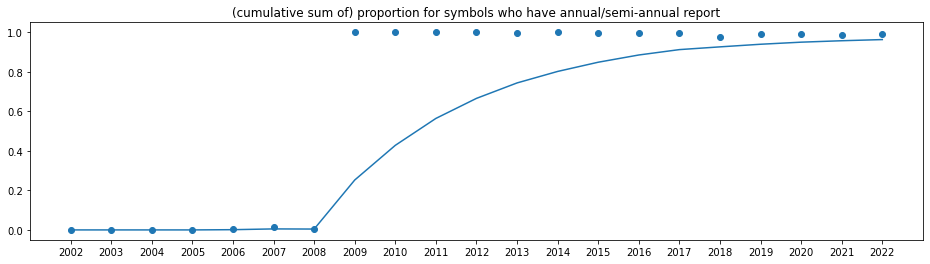

In [42]:
allocation['report_type_check'] = allocation.EndDate.dt.asfreq('y')
report_type_check = allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index.astype(str), y=report_type_check_.values)
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index.astype(str), temp.values)
plt.title('(cumulative sum of) proportion for symbols who have annual/semi-annual report')
pass

<img src="attachment/2008_search.png" alt="drawing" width="500"/> <img src="attachment/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


In [43]:
%%time
# CrossCodes do not matter
allocation['proportion'] = allocation.Equity / allocation.TotalAsset
allocation['flag'] = allocation.proportion > .3
allocation.groupby(['MasterFundCode', 'EndDate']).apply(lambda cross_code: cross_code.proportion)

CPU times: total: 25.9 s
Wall time: 27.1 s


MasterFundCode  EndDate        
1               2002-03  0         0.322983
                         1         0.323000
                2002-06  2         0.441513
                         3         0.441500
                2002-09  4         0.462637
                                     ...   
980003          2022-03  646977         NaN
                2022-06  646978         NaN
                         646979         NaN
                         646980         NaN
                         646981         NaN
Name: proportion, Length: 646982, dtype: float64

In [44]:
# keep only one CrossCode per report period per symbol
def func(temp):
    if temp.flag.any():
        return temp[temp.flag].iloc[0]

allocation_ = allocation.groupby(['MasterFundCode', 'EndDate']).apply(func)

#### iv. check: Fund_ShareChange

基金概况 — 份额变动文件

**erratum**

*problem*: ≈1% wrong `Fund_ShareChange`

*reason*: wrong data

*solve*: keep the last one

In [45]:
share_info_erratum = share_info.set_index(['Symbol', 'EndDate'])
filter_share = share_info_erratum.groupby(['Symbol', 'EndDate'])\
    .apply(lambda duplicated: True if len(duplicated.EndDateShares.unique()) == 1 else False)
share_info_erratum_ = share_info_erratum.loc[filter_share[~filter_share].index]
share_info_erratum_

ReportTypeID  EndDateShares
Symbol EndDate                             
28     2019-06             2   1.072282e+08
       2019-06             5   1.072282e+08
       2019-06             6   1.072282e+08
       2019-06             2   8.847101e+07
       2019-06             5   8.847101e+07
...                      ...            ...
970058 2021-12             6   7.161019e+07
970059 2021-12             4            NaN
       2021-12             6   1.251201e+07
970060 2021-12             4            NaN
       2021-12             6   6.645630e+07

[2328 rows x 2 columns]

e.g.

`Symbol == 28`


In [46]:
share_info_erratum_.loc[28, slice(None)]

,ReportTypeID,EndDateShares
EndDate,,
2019-06,2,1.072282e+08
2019-06,5,1.072282e+08
2019-06,6,1.072282e+08
2019-06,2,8.847101e+07
2019-06,5,8.847101e+07


e.g.

`Symbol == 970059`


In [47]:
share_info_erratum_.loc[970059, slice(None)]

,ReportTypeID,EndDateShares
EndDate,,
2021-12,4,NaN
2021-12,6,12512009.66


e.g.

`Symbol == 970060`


In [48]:
share_info_erratum_.loc[970060, slice(None)]

,ReportTypeID,EndDateShares
EndDate,,
2021-12,4,NaN
2021-12,6,66456295.68


In [49]:
round_(len(share_info_erratum_) / len(share_info_erratum)) + ' Symbol-Month in `share_info` have more than one `EndDateShares`'

'0.5700000000000001% Symbol-Month in `share_info` have more than one `EndDateShares`'

<img src="attachment/share_erratum.png" alt="drawing" width="600"/>

In [50]:
share_info_ = share_info.groupby(['Symbol', 'EndDate', 'ReportTypeID']).last().reset_index(['ReportTypeID'])
round_(1 - len(share_info_) / len(share_info)) + ' wrong data in `share_info` deleted'

'0.09% wrong data in `share_info` deleted'

#### v. last 2 : dynamic filtering

（5）基金上市时间超过一年

In [51]:
filter_5 = main_data.EndDate >= main_data.InceptionDate + pd.offsets.MonthEnd(12)

f'filter 5: {len(main_data)} to {filter_5.sum()}, {round_(1 - filter_5.sum() / len(main_data))} Symbol-Month dropped'
# Symbol statistic

'filter 5: 144418 to 111230, 22.98% Symbol-Month dropped'

In [52]:
main_data[filter_5]

,Symbol,EndDate,InceptionDate,MasterFundCode,Category,FullName
4,6,2020-03,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
5,6,2020-06,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
6,6,2020-09,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
7,6,2020-12,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
8,6,2021-03,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
...,...,...,...,...,...,...
144323,970048,2022-09,2021-07,970048,混合型基金,东海证券海睿致远灵活配置混合型集合资产管理计划
144332,970051,2022-09,2021-09,970051,混合型基金,银河安丰九个月滚动持有混合型集合资产管理计划
144337,970067,2022-09,2021-08,970068,混合型基金,兴证资管金麒麟消费升级混合型集合资产管理计划
144342,970068,2022-09,2021-08,970068,混合型基金,兴证资管金麒麟消费升级混合型集合资产管理计划


In [53]:
main_data_5 = main_data[main_data.EndDate >= main_data.InceptionDate + pd.offsets.MonthEnd(12)].reset_index(drop=True)
main_data_5

,Symbol,EndDate,InceptionDate,MasterFundCode,Category,FullName
0,6,2020-03,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
1,6,2020-06,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
2,6,2020-09,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
3,6,2020-12,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
4,6,2021-03,2019-03,6,混合型基金,西部利得量化成长混合型发起式证券投资基金
...,...,...,...,...,...,...
111225,970048,2022-09,2021-07,970048,混合型基金,东海证券海睿致远灵活配置混合型集合资产管理计划
111226,970051,2022-09,2021-09,970051,混合型基金,银河安丰九个月滚动持有混合型集合资产管理计划
111227,970067,2022-09,2021-08,970068,混合型基金,兴证资管金麒麟消费升级混合型集合资产管理计划
111228,970068,2022-09,2021-08,970068,混合型基金,兴证资管金麒麟消费升级混合型集合资产管理计划


（6）最近一次 **二季度报/年报/半年报** ~~年报或半年报~~ 披露的中国市场股票持股比例超过总管理规模的 30%

In [54]:
allocation_['flag'] = allocation_.proportion > .3
main_data_6 = pd.merge(main_data_5, allocation_[allocation_.flag].drop(['MasterFundCode', 'EndDate'], axis=1), on=['MasterFundCode', 'EndDate'])\
    .set_index(['Symbol', 'EndDate'])[['InceptionDate', 'MasterFundCode', 'Category', 'FullName']]
main_data_6

InceptionDate  MasterFundCode Category  \
Symbol EndDate                                          
6      2020-03       2019-03               6    混合型基金   
       2020-06       2019-03               6    混合型基金   
       2020-09       2019-03               6    混合型基金   
       2020-12       2019-03               6    混合型基金   
       2021-03       2019-03               6    混合型基金   
...                      ...             ...      ...   
970021 2022-03       2021-03          970021    混合型基金   
970020 2022-06       2021-03          970021    混合型基金   
970021 2022-06       2021-03          970021    混合型基金   
970032 2022-06       2021-06          970033    混合型基金   
970033 2022-06       2021-06          970033    混合型基金   

                                  FullName  
Symbol EndDate                              
6      2020-03        西部利得量化成长混合型发起式证券投资基金  
       2020-06        西部利得量化成长混合型发起式证券投资基金  
       2020-09        西部利得量化成长混合型发起式证券投资基金  
       2020-12        西部利得量化成长混合型发起式证券投资基金  
       2021-03        西部利得量化成长混合型发起式证券投资基金  
...                                    ...  
970021 2022-03  信达价值精选一年持有期灵活配置混合型集合资产管理计划  
970020 2022-06  信达价值精选一年持有期灵活配置混合型集合资产管理计划  
970021 2022-06  信达价值精选一年持有期灵活配置混合型集合资产管理计划  
970032 2022-06     东海证券海睿进取灵活配置混合型集合资产管理计划  
970033 2022-06     东海证券海睿进取灵活配置混合型集合资产管理计划  

[72576 rows x 4 columns]

In [55]:
f'filter 6: {len(main_data_5)} to {len(main_data_6)}, {round_(1 - len(main_data_6) / len(main_data_5))} Symbol-Month dropped'

'filter 6: 111230 to 72576, 34.75% Symbol-Month dropped'

In [56]:
nav = pickle.load(open('data\Wind_NAV.pkl', 'rb'))

In [57]:
nav.head(5)

,ANN_DATE,CRNCY_CODE,F_ASSET_MERGEDSHARESORNOT,F_INFO_WINDCODE,F_NAV_ACCUMULATED,F_NAV_ADJFACTOR,F_NAV_ADJUSTED,F_NAV_DISTRIBUTION,F_NAV_DIVACCUMULATED,F_NAV_UNIT,F_PRT_NETASSET,IS_EXDIVIDENDDATE,NETASSET_TOTAL,OBJECT_ID,OPDATE,OPMODE,PRICE_DATE,S_INFO_ASHARECODE
0,NaN,NaN,0,020007.OF,NaN,10827.857168,10827.8572,NaN,NaN,1.0,2.408635e+08,NaN,2.408635e+08,{59F6D6F2-FD3B-3D78-E040-007F010074D8},2013/6/1 14:09:30,0,20080930,S12527
1,NaN,CNY,0,260102.OF,NaN,10325.393195,10325.3932,NaN,NaN,1.0,2.316152e+08,0.0,2.316152e+08,{F98EAC7D-FC00-435D-B9F4-F592938CD25D},2016/2/17 20:42:20,0,20070331,S10329
2,NaN,CNY,0,240006.OF,NaN,10378.169425,10378.1694,NaN,NaN,1.0,1.812202e+08,0.0,3.978773e+08,{D85C1B6C-E224-47AB-B6D9-4A80005FF811},2013/6/1 14:14:16,0,20070331,S12310
3,NaN,CNY,0,240007.OF,NaN,10428.349306,10428.3493,NaN,NaN,1.0,2.166570e+08,0.0,NaN,{AEE39FFA-BDC1-47D9-93D5-1042300DC192},2013/6/1 14:15:49,0,20070331,S12311
4,NaN,CNY,0,519588.OF,NaN,10234.500716,10234.5007,NaN,NaN,1.0,1.039695e+09,0.0,1.039695e+09,{C63DBDE4-B398-4468-AB84-88E78A6FD230},2013/6/1 14:08:56,0,20070331,S13294


In [58]:
nav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14268372 entries, 0 to 2893130
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ANN_DATE                   float64
 1   CRNCY_CODE                 object 
 2   F_ASSET_MERGEDSHARESORNOT  int64  
 3   F_INFO_WINDCODE            object 
 4   F_NAV_ACCUMULATED          float64
 5   F_NAV_ADJFACTOR            float64
 6   F_NAV_ADJUSTED             float64
 7   F_NAV_DISTRIBUTION         float64
 8   F_NAV_DIVACCUMULATED       float64
 9   F_NAV_UNIT                 float64
 10  F_PRT_NETASSET             float64
 11  IS_EXDIVIDENDDATE          float64
 12  NETASSET_TOTAL             float64
 13  OBJECT_ID                  object 
 14  OPDATE                     object 
 15  OPMODE                     int64  
 16  PRICE_DATE                 int64  
 17  S_INFO_ASHARECODE          object 
dtypes: float64(10), int64(3), object(5)
memory usage: 2.0+ GB


In [59]:
nav.columns

Index(['ANN_DATE', 'CRNCY_CODE', 'F_ASSET_MERGEDSHARESORNOT',
       'F_INFO_WINDCODE', 'F_NAV_ACCUMULATED', 'F_NAV_ADJFACTOR',
       'F_NAV_ADJUSTED', 'F_NAV_DISTRIBUTION', 'F_NAV_DIVACCUMULATED',
       'F_NAV_UNIT', 'F_PRT_NETASSET', 'IS_EXDIVIDENDDATE', 'NETASSET_TOTAL',
       'OBJECT_ID', 'OPDATE', 'OPMODE', 'PRICE_DATE', 'S_INFO_ASHARECODE'],
      dtype='object')

In [60]:
fund_nav = nav[nav.F_INFO_WINDCODE.apply(lambda row: True if 'OF' in row else False)]

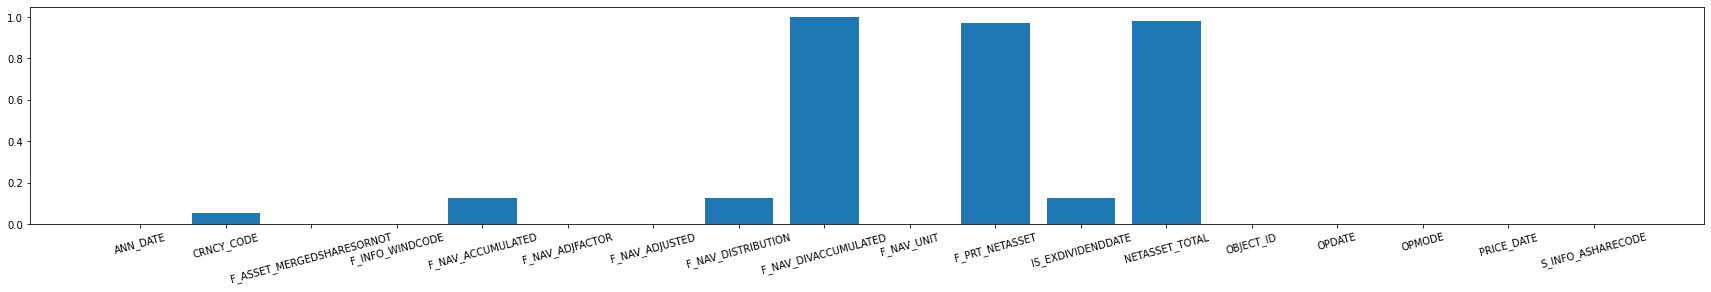

In [61]:
temp = pd.isnull(fund_nav).sum() / len(fund_nav)

plt.figure(figsize=(30, 4))
plt.bar(temp.index, temp.values)
plt.xticks(rotation=15)
pass

In [62]:
nav.loc[0].F_INFO_WINDCODE

0      020007.OF
0      200003.OF
0    270046!1.OF
0      511680.SH
0      009251.OF
0      007151.OF
Name: F_INFO_WINDCODE, dtype: object

In [63]:
fund_nav[fund_nav.F_INFO_WINDCODE == '160814.OF'].sort_values('PRICE_DATE').tail(2)

,ANN_DATE,CRNCY_CODE,F_ASSET_MERGEDSHARESORNOT,F_INFO_WINDCODE,F_NAV_ACCUMULATED,F_NAV_ADJFACTOR,F_NAV_ADJUSTED,F_NAV_DISTRIBUTION,F_NAV_DIVACCUMULATED,F_NAV_UNIT,F_PRT_NETASSET,IS_EXDIVIDENDDATE,NETASSET_TOTAL,OBJECT_ID,OPDATE,OPMODE,PRICE_DATE,S_INFO_ASHARECODE
2625296,20211231.0,CNY,0,160814.OF,0.9375,1.156552,1.084267,0.0,NaN,0.9375,NaN,0.0,NaN,{EEFB122E-696A-11EC-960F-D45D643C1D33},2021/12/31 11:56:18,0,20211230,S5389473
2558481,20220101.0,CNY,0,160814.OF,0.9395,1.156552,1.086580,0.0,NaN,0.9395,NaN,0.0,NaN,{8312C311-6A48-11EC-B536-D45D64A97096},2021/12/31 22:51:18,0,20211231,S5389473


In [64]:
fund_nav[fund_nav.F_INFO_WINDCODE == '020007.OF'].sort_values('PRICE_DATE').tail(2)

,ANN_DATE,CRNCY_CODE,F_ASSET_MERGEDSHARESORNOT,F_INFO_WINDCODE,F_NAV_ACCUMULATED,F_NAV_ADJFACTOR,F_NAV_ADJUSTED,F_NAV_DISTRIBUTION,F_NAV_DIVACCUMULATED,F_NAV_UNIT,F_PRT_NETASSET,IS_EXDIVIDENDDATE,NETASSET_TOTAL,OBJECT_ID,OPDATE,OPMODE,PRICE_DATE,S_INFO_ASHARECODE
2613911,20211231.0,CNY,0,020007.OF,NaN,15890.751029,15890.7510,NaN,NaN,1.0,NaN,NaN,NaN,{51122B32-6966-11EC-B535-D45D64A97096},2021/12/31 11:56:58,1,20211230,S12527
2614052,20220101.0,CNY,0,020007.OF,NaN,15891.798547,15891.7985,NaN,NaN,1.0,NaN,NaN,NaN,{30D735FC-6A37-11EC-B536-D45D64A97096},2021/12/31 20:51:13,1,20211231,S12527


In [65]:
fund_nav_ = fund_nav[['PRICE_DATE', 'F_INFO_WINDCODE', 'F_NAV_ADJUSTED', 'F_NAV_ACCUMULATED']]

<AxesSubplot:xlabel='PRICE_DATE'>

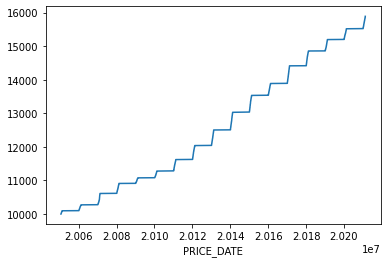

In [66]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '020007.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

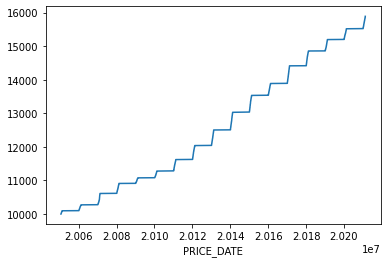

In [67]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '020007.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

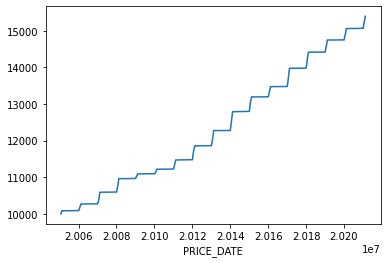

In [68]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '260102.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

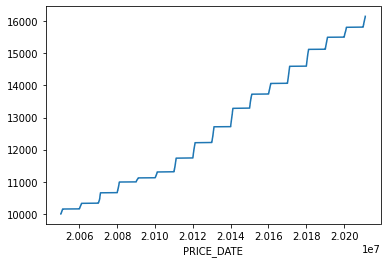

In [69]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '240006.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

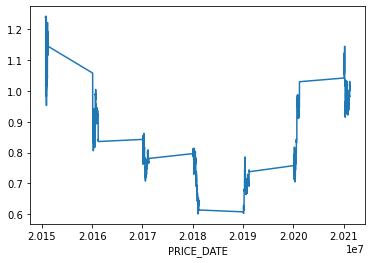

In [70]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '080015.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

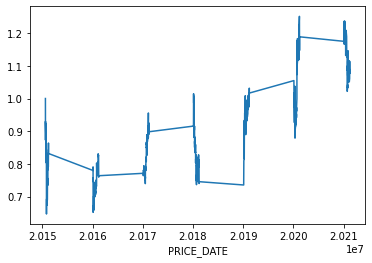

In [71]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '160814.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()


<AxesSubplot:xlabel='PRICE_DATE'>

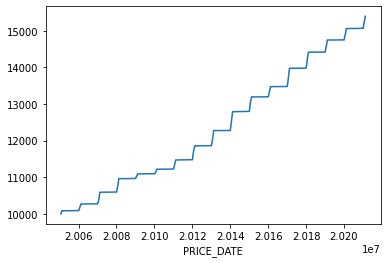

In [72]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '260102.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

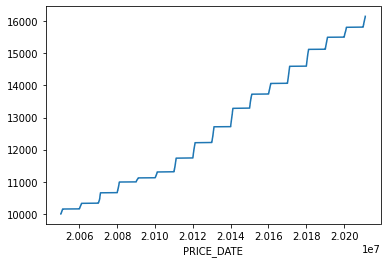

In [73]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '240006.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

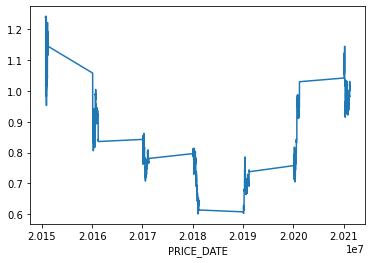

In [74]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '080015.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

<AxesSubplot:xlabel='PRICE_DATE'>

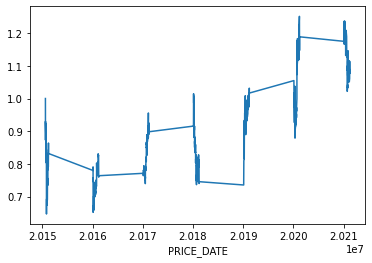

In [75]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '160814.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()


<AxesSubplot:xlabel='PRICE_DATE'>

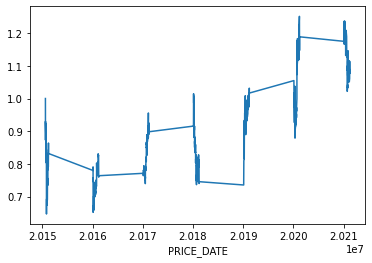

In [76]:
fund_nav_[fund_nav_.F_INFO_WINDCODE == '160814.OF'].set_index('PRICE_DATE').sort_index().F_NAV_ADJUSTED.plot()

In [77]:

csmar_symbol = fund_nav_.F_INFO_WINDCODE.apply(\
    lambda x: x.replace('.OF', '') if not any(value in x for value in ('!', 'B', 'A')) else 0)



In [78]:
fund_nav_['Symbol'] = csmar_symbol.astype(int)

C:\Users\11633\AppData\Local\Temp\ipykernel_21516\873389468.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
(csmar_symbol == 0).sum() / len(csmar_symbol)

0.023192934758854797

In [80]:
fund_nav__ = fund_nav_[csmar_symbol != 0]

In [81]:
full_symbol_code

NameError: name 'full_symbol_code' is not defined

In [ ]:
fund_nav__['Category'] = pd.merge(fund_nav__.Symbol, full_symbol_code[['Symbol', 'Category']], how='left', on='Symbol').Category

C:\Users\11633\AppData\Local\Temp\ipykernel_22584\2182456968.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fund_nav___ = fund_nav__[np.logical_or(fund_nav__.Category == '混合型基金', fund_nav__.Category == '股票型基金')]
fund_nav___

,PRICE_DATE,F_INFO_WINDCODE,F_NAV_ADJUSTED,F_NAV_ACCUMULATED,Symbol,Category
345,20060120,519588.OF,10000.000000,NaN,519588,混合型基金
346,20050331,240006.OF,10000.000000,NaN,240006,混合型基金
347,20050331,240007.OF,10000.000000,NaN,240007,混合型基金
349,20050413,370010.OF,10000.000000,NaN,370010,混合型基金
350,20060707,310338.OF,10000.000000,NaN,310338,混合型基金
...,...,...,...,...,...,...
2893117,20211221,080007.OF,1.675000,1.706,80007,股票型基金
2893118,20211221,010991.OF,1.663000,1.663,10991,股票型基金
2893119,20211221,080008.OF,2.732447,2.655,80008,混合型基金
2893120,20211221,001834.OF,1.231001,1.468,1834,混合型基金


In [ ]:
fund_nav___['EndDate'] = pd.to_datetime(fund_nav___.PRICE_DATE.astype(str)).dt.to_period('M')

C:\Users\11633\AppData\Local\Temp\ipykernel_22584\1173896099.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fund_nav___

,PRICE_DATE,F_INFO_WINDCODE,F_NAV_ADJUSTED,F_NAV_ACCUMULATED,Symbol,Category,EndDate
345,20060120,519588.OF,10000.000000,NaN,519588,混合型基金,2006-01
346,20050331,240006.OF,10000.000000,NaN,240006,混合型基金,2005-03
347,20050331,240007.OF,10000.000000,NaN,240007,混合型基金,2005-03
349,20050413,370010.OF,10000.000000,NaN,370010,混合型基金,2005-04
350,20060707,310338.OF,10000.000000,NaN,310338,混合型基金,2006-07
...,...,...,...,...,...,...,...
2893117,20211221,080007.OF,1.675000,1.706,80007,股票型基金,2021-12
2893118,20211221,010991.OF,1.663000,1.663,10991,股票型基金,2021-12
2893119,20211221,080008.OF,2.732447,2.655,80008,混合型基金,2021-12
2893120,20211221,001834.OF,1.231001,1.468,1834,混合型基金,2021-12


In [ ]:
fund_nav___[fund_nav___.EndDate.apply(lambda x: x.month) == 6]

,PRICE_DATE,F_INFO_WINDCODE,F_NAV_ADJUSTED,F_NAV_ACCUMULATED,Symbol,Category,EndDate
421,20050602,091005.OF,10000.000000,NaN,91005,混合型基金,2005-06
428,20070621,519589.OF,10000.000000,NaN,519589,混合型基金,2007-06
5317,20020614,000001.OF,1.018000,1.0180,1,混合型基金,2002-06
5323,20020625,020001.OF,1.017000,1.0170,20001,混合型基金,2002-06
5551,20020630,000001.OF,1.100300,1.1000,1,混合型基金,2002-06
...,...,...,...,...,...,...,...
2388298,20210617,970041.OF,2.282674,1.6582,970041,混合型基金,2021-06
2388300,20210621,970041.OF,2.317276,1.6813,970041,混合型基金,2021-06
2388301,20210622,970041.OF,2.332405,1.6914,970041,混合型基金,2021-06
2388304,20210625,970041.OF,2.382436,1.7248,970041,混合型基金,2021-06


In [ ]:
_.groupby(['EndDate', 'Symbol']).last()

PRICE_DATE F_INFO_WINDCODE  F_NAV_ADJUSTED  F_NAV_ACCUMULATED  \
EndDate Symbol                                                                  
2002-06 1         20020607       000001.OF        1.033000             1.0330   
        20001     20020627       020001.OF        1.026000             1.0260   
        40001     20020610       040001.OF        1.024000             1.0240   
        202001    20020607       202001.OF        1.029078             1.0293   
2003-06 1         20030630       000001.OF        1.031200             1.0330   
...                    ...             ...             ...                ...   
2021-06 970033    20210624       970033.OF        0.977500             0.9775   
        970034    20210623       970034.OF        1.000600             1.0006   
        970041    20210628       970041.OF        2.392022             1.7312   
        970071    20210617       970071.OF        1.684815             1.5410   
        980003    20210616       980003.OF        1.470400             1.4704   

               Category  
EndDate Symbol           
2002-06 1         股票型基金  
        20001     混合型基金  
        40001     混合型基金  
        202001    混合型基金  
2003-06 1         混合型基金  
...                 ...  
2021-06 970033    混合型基金  
        970034    混合型基金  
        970041    混合型基金  
        970071    混合型基金  
        980003    股票型基金  

[53043 rows x 5 columns]

In [ ]:
temp = _

In [ ]:
temp2 = pd.merge(temp, full_share_info, on=['EndDate', 'Symbol'])

In [ ]:
temp2['mkt'] = temp2.F_NAV_ACCUMULATED * temp2.EndDateShares

<AxesSubplot:xlabel='EndDate'>

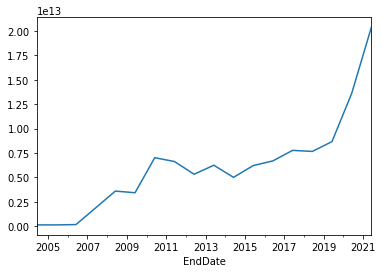

In [ ]:
temp2[temp2.Category == '混合型基金'].groupby('EndDate').apply(lambda x: x.mkt.sum()).plot()

<AxesSubplot:xlabel='EndDate'>

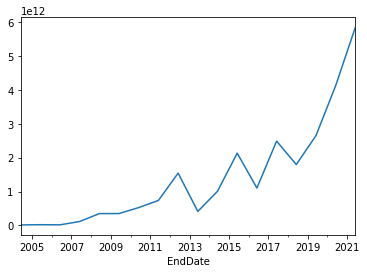

In [ ]:
temp2[temp2.Category == '股票型基金'].groupby('EndDate').apply(lambda x: x.mkt.sum()).plot()

### **3. full market statistic**

here we do not apply 6 filters

#### i. fund num count && fund market value

In [ ]:
full_maininfo = pd.read_csv('FUND_MainInfo.csv', parse_dates=['InceptionDate'])
full_maininfo['InceptionDate'] = full_maininfo.InceptionDate.dt.to_period('M')

full_unitclassinfo = pd.read_csv('FUND_UnitClassInfo.csv', parse_dates=['InceptionDate'])
full_unitclassinfo['InceptionDate'] = full_unitclassinfo.InceptionDate.dt.to_period('M')
full_unitclassinfo['MasterFundCode'] = full_unitclassinfo.MasterFundCode.astype('Int64')

full_share_info = pd.read_csv('Fund_ShareChange.csv', parse_dates=['EndDate'])
full_share_info['EndDate'] = full_share_info.EndDate.dt.to_period('M')

full_nav_month = pd.read_csv('Fund_NAV_Month.csv', parse_dates=['TradingDate'])
full_nav_month['TradingDate'] = full_nav_month.TradingDate.dt.to_period('M')
full_nav_month['EndDate'] = full_nav_month.TradingDate

In [ ]:
full_symbol_code = pd.merge(full_unitclassinfo.dropna(subset='MasterFundCode'), full_maininfo, on='MasterFundCode')[['MasterFundCode', 'Symbol', 'Category', 'FullName', 'InceptionDate_x']]
full_symbol_code.columns = ['MasterFundCode', 'Symbol', 'Category', 'FullName', 'InceptionDate']
full_symbol_code = full_symbol_code.drop_duplicates(subset='Symbol', keep='last')
full_symbol_code

,MasterFundCode,Symbol,Category,FullName,InceptionDate
0,1,1,混合型基金,华夏成长证券投资基金,2001-12
1,3,3,债券型基金,中海可转换债券债券型证券投资基金,2013-03
2,3,4,债券型基金,中海可转换债券债券型证券投资基金,2013-03
3,5,5,债券型基金,嘉实增强信用定期开放债券型证券投资基金,2013-03
4,6,6,混合型基金,西部利得量化成长混合型发起式证券投资基金,2019-03
...,...,...,...,...,...
20125,970187,970187,货币型基金,申万宏源天添利货币型集合资产管理计划,2022-08
20126,970191,970191,货币型基金,申万宏源天天增货币型集合资产管理计划,2022-08
20127,970194,970194,FOF,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,2022-09
20128,970194,970195,FOF,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,2022-09


In [58]:
full_symbol_code

,MasterFundCode,Symbol,Category,FullName,InceptionDate
0,1,1,混合型基金,华夏成长证券投资基金,2001-12
1,3,3,债券型基金,中海可转换债券债券型证券投资基金,2013-03
2,3,4,债券型基金,中海可转换债券债券型证券投资基金,2013-03
3,5,5,债券型基金,嘉实增强信用定期开放债券型证券投资基金,2013-03
4,6,6,混合型基金,西部利得量化成长混合型发起式证券投资基金,2019-03
...,...,...,...,...,...
20125,970187,970187,货币型基金,申万宏源天添利货币型集合资产管理计划,2022-08
20126,970191,970191,货币型基金,申万宏源天天增货币型集合资产管理计划,2022-08
20127,970194,970194,FOF,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,2022-09
20128,970194,970195,FOF,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,2022-09


**erratum**

*problem*: in mixed fund, <1% net asset value is 0

*reason*: money market fund

*solve*: ignore

In [59]:
f'{round_((full_nav_month.NAV == 0).sum() / len(full_nav_month))} net asset value is 0'

'8.4% net asset value is 0'

In [60]:
# nav_month__ = nav_month_.replace(0, np.nan)
# nav_month__
f'{round_((full_nav_month.NAV == 0).sum() / len(full_nav_month))} values is 0'
display(full_nav_month[full_nav_month.NAV == 0])
full_nav_month[full_nav_month.NAV == 0][full_nav_month[full_nav_month.NAV == 0].Symbol == 9]

,TradingDate,TradingMonth,Symbol,NAV,EndDate
813,2013-03,2013-03,9,0.0,2013-03
814,2013-04,2013-04,9,0.0,2013-04
815,2013-05,2013-05,9,0.0,2013-05
816,2013-06,2013-06,9,0.0,2013-06
817,2013-07,2013-07,9,0.0,2013-07
...,...,...,...,...,...
869699,2022-08,2022-08,970178,0.0,2022-08
869700,2022-07,2022-07,970180,0.0,2022-07
869701,2022-08,2022-08,970180,0.0,2022-08
869706,2022-08,2022-08,970187,0.0,2022-08


,TradingDate,TradingMonth,Symbol,NAV,EndDate
813,2013-03,2013-03,9,0.0,2013-03
814,2013-04,2013-04,9,0.0,2013-04
815,2013-05,2013-05,9,0.0,2013-05
816,2013-06,2013-06,9,0.0,2013-06
817,2013-07,2013-07,9,0.0,2013-07
...,...,...,...,...,...
922,2022-04,2022-04,9,0.0,2022-04
923,2022-05,2022-05,9,0.0,2022-05
924,2022-06,2022-06,9,0.0,2022-06
925,2022-07,2022-07,9,0.0,2022-07


<img src="attachment/NAV.png" alt="drawing" width="1200"/>

In [61]:
symboled_full_nav_month = pd.merge(full_nav_month, full_symbol_code, on='Symbol')
symboled_full_nav_month[symboled_full_nav_month.NAV == 0].Category.value_counts()

货币型基金    64343
债券型基金     8354
混合型基金      133
Name: Category, dtype: int64

In [62]:
round_((symboled_full_nav_month[symboled_full_nav_month.NAV == 0].Category == '混合型基金').sum() / len(symboled_full_nav_month)) + ' net asset value is 0'

'0.02% net asset value is 0'

In [63]:
full_nav_month['NAV'].fillna(0, inplace=True)

**erratum**

*problem*: almost all ≈95% `share` funds did not report `share` on the first quarter in which it was founded

*reason*: -

*solve*: ignore

e.g. `Symbol == 20001`

In [64]:
full_nav_month[full_nav_month.Symbol == 20001].sort_values('EndDate').head(5)

,TradingDate,TradingMonth,Symbol,NAV,EndDate
544507,2002-05,2002-05,20001,1.000,2002-05
544508,2002-06,2002-06,20001,1.027,2002-06
544509,2002-07,2002-07,20001,1.010,2002-07
544510,2002-08,2002-08,20001,1.016,2002-08
544511,2002-09,2002-09,20001,0.984,2002-09


In [65]:
full_share_info[full_share_info.Symbol == 20001].sort_values('EndDate').head(5)

,Symbol,ReportTypeID,EndDate,EndDateShares
253185,20001,2,2004-06,1.273287e+09
253186,20001,3,2004-09,1.253561e+09
253187,20001,4,2004-12,9.161155e+08
253188,20001,1,2005-03,9.079695e+08
253189,20001,2,2005-06,8.695486e+08


<img src="attachment/200001.png" alt="drawing" width="800"/>

In [66]:
share_init_month = full_share_info.groupby('Symbol').apply(lambda x: x.EndDate.iloc[0])
nav_init_month = full_nav_month.groupby('Symbol').apply(lambda x: x.EndDate.iloc[0])
co_quarter = np.intersect1d(nav_init_month.index, share_init_month.index)
round_((nav_init_month.loc[co_quarter] != share_init_month.loc[co_quarter]).sum() / len(co_quarter)) + ' funds did not report share info on the first quarter in which it was founded'

'96.33% funds did not report share info on the first quarter in which it was founded'

In [67]:
full_share_nav = pd.merge(full_share_info, full_nav_month, on=['Symbol', 'EndDate'])
full_share_nav['mkt_value'] = full_share_nav.NAV * full_share_nav.EndDateShares
full_share_nav = pd.merge(full_share_nav, full_symbol_code, on='Symbol')[['Symbol', 'ReportTypeID', 'EndDate', 'mkt_value', 'MasterFundCode', 'Category', 'FullName', 'InceptionDate']]

In [68]:
fund_num_count = pd.merge(full_nav_month, full_symbol_code, on=['Symbol'])
stock_fund_count = fund_num_count[fund_num_count.Category == '股票型基金'].groupby('EndDate').apply(lambda x: len(x.Symbol.unique()))
stock_fund_count.index = stock_fund_count.index.astype(np.datetime64)
mixed_fund_count = fund_num_count[fund_num_count.Category == '混合型基金'].groupby('EndDate').apply(lambda x: len(x.Symbol.unique()))
mixed_fund_count.index = mixed_fund_count.index.astype(np.datetime64)

In [69]:
stock_fund_mkt_value = full_share_nav[full_share_nav.Category == '股票型基金'].groupby('EndDate').apply(lambda x: x.mkt_value.sum())
mixed_fund_mkt_value = full_share_nav[full_share_nav.Category == '混合型基金'].groupby('EndDate').apply(lambda x: x.mkt_value.sum())


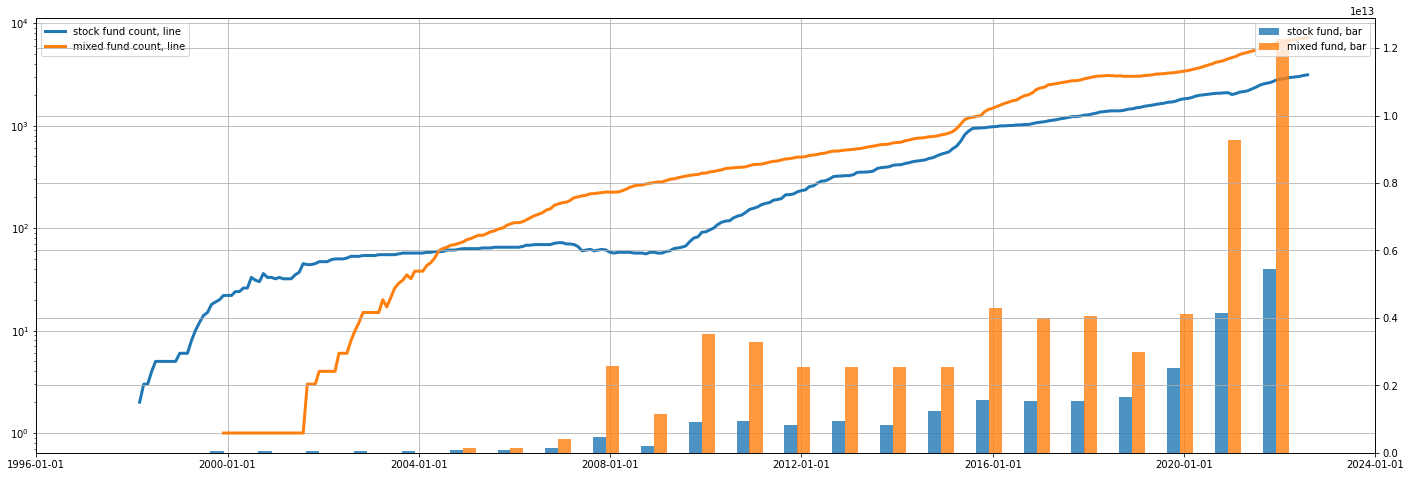

In [70]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

ax1.plot(stock_fund_count, linewidth=3, label='stock fund count, line')
ax1.plot(mixed_fund_count, linewidth=3, label='mixed fund count, line')
ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()

ax2 = ax1.twinx()

selected_month = 12

ax2.bar(stock_fund_mkt_value[stock_fund_mkt_value.index.month == selected_month].index.astype(np.datetime64) - pd.Timedelta('7W'),\
     stock_fund_mkt_value[stock_fund_mkt_value.index.month == selected_month].values, width=100, label='stock fund, bar', alpha=.8)

ax2.bar(mixed_fund_mkt_value[mixed_fund_mkt_value.index.month == selected_month].index.astype(np.datetime64) + pd.Timedelta('7W'),\
     mixed_fund_mkt_value[mixed_fund_mkt_value.index.month == selected_month].values, width=100, label='mixed fund, bar', alpha=.8)


# ? 国泰安份额
# 选择数据库
# 单位净值/复权净值
# joinquant净值/wind净值

ax2.grid()
ax2.set_xticks(ax2.get_xticks()[::1])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# 19年涨幅对比
# wind数据净值
pass

#### ii. fund management fees

**erratum**

*problem*: date begins at 2003-05

*reason*: 

*solve*: 

In [71]:
fees_ = fees[np.logical_or(fees.NameOfFee == '管理费率', fees.NameOfFee == '托管费率')]
fees_ = fees_.astype({'ProportionOfFee': 'float'})
fees_ = fees_.drop_duplicates(subset=['Symbol', 'DeclareDate', 'NameOfFee'], keep='last')
fees_ = fees_.groupby(['Symbol', 'DeclareDate']).sum().reset_index()
fees_ = fees_[fees_.ProportionOfFee < 5]
fees_

,Symbol,DeclareDate,ProportionOfFee
0,1,2006-08,1.75
1,1,2007-02,1.75
2,1,2007-08,1.75
3,1,2008-02,1.75
4,1,2008-08,1.75
...,...,...,...
144393,970195,2022-09,0.90
144394,980003,2020-04,0.55
144395,980003,2020-06,0.55
144396,980003,2022-02,0.55


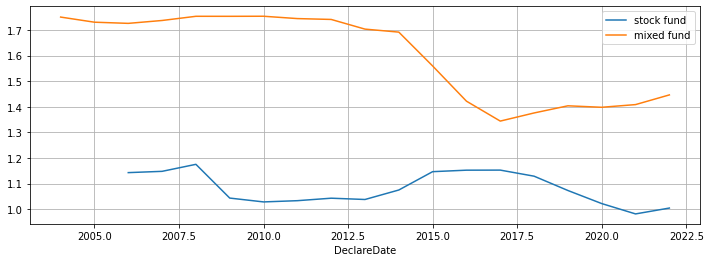

In [102]:
plt.figure(figsize=(12, 4))
fees__ = pd.merge(fees_, full_symbol_code[['Symbol', 'Category']], on='Symbol')
fees__['DeclareDate'] = fees__.DeclareDate.apply(lambda month: month.year)
fees__[fees__.Category == '股票型基金'].groupby('DeclareDate').apply(lambda x: x.ProportionOfFee.mean()).plot(label='stock fund')
fees__[fees__.Category == '混合型基金'].groupby('DeclareDate').apply(lambda x: x.ProportionOfFee.mean()).plot(label='mixed fund')
plt.legend()
plt.grid()

### **4. fund return**

#### i. check: Fund_Resolution, Fund_FundDividend

收益分配与拆分 — 基金分配文件

收益分配与拆分 — 基金拆分信息文件


SecondaryExDividendDate [场内除息日] - 

PrimaryExDividendDate [场外除息日] - 

In [73]:
round_(pd.isnull(resolution.SplitRatio).sum() / len(resolution)) + ' split ratio is null'

'0.13% split ratio is null'

In [74]:
resolution.dropna(inplace=True)

In [75]:
f'{round_(pd.isnull(fund_dividend.PrimaryExDividendDate).sum() / len(fund_dividend))} `PrimaryExDividendDate` is not available'

'1.28% `PrimaryExDividendDate` is not available'

In [76]:
f'{round_(pd.isnull(fund_dividend.SecondaryExDividendDate).sum() / len(fund_dividend))} `SecondaryExDividendDate` is not available'

'92.64% `SecondaryExDividendDate` is not available'

In [77]:
temp = fund_dividend.apply(lambda row: True if pd.notnull(row.SecondaryExDividendDate) and pd.isna(row.PrimaryExDividendDate) else False, axis=1).sum() / len(fund_dividend)
f'when `PrimaryExDividendDate` is not available, there stands {round_(temp)} chance `SecondaryExDividendDate` is available'

'when `PrimaryExDividendDate` is not available, there stands 1.28% chance `SecondaryExDividendDate` is available'

In [78]:
ExDividendMonth = fund_dividend.PrimaryExDividendDate.copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth


In [79]:
temp = fund_dividend.groupby(['Symbol', 'ExDividendMonth']).apply(lambda one_month: len(one_month))
f'{round_(len(temp[temp != 1]) / len(temp))} funds have multiple dividend payouts in one month'

'1.28% funds have multiple dividend payouts in one month'

In [80]:
temp = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio
f'{round_(len(temp[temp.index.duplicated(keep=False)]) / len(temp))} funds have multiple divisions in one month'

'1.02% funds have multiple divisions in one month'

In [81]:
dividend = fund_dividend.groupby(['Symbol', 'ExDividendMonth']).apply(lambda x: x.DividendperShare.sum())
dividend.name = 'fund_dividend'
dividend

Symbol  ExDividendMonth
1       2002-06            0.0270
        2003-06            0.0330
        2004-06            0.0300
        2004-12            0.0300
        2006-04            0.0200
                            ...  
970071  2022-08            0.0090
970072  2022-08            0.0300
970086  2022-08            0.0180
970106  2022-07            0.0185
970124  2022-08            0.0200
Name: fund_dividend, Length: 29429, dtype: float64

In [82]:
split = resolution.groupby(['Symbol', 'DeclareDate']).apply(lambda x: x.SplitRatio.cumprod()).droplevel(2)
split

Symbol  DeclareDate
28      2016-04        0.998495
30      2016-04        1.851295
53      2018-11        1.454000
58      2016-04        1.171550
66      2016-04        1.411347
                         ...   
870017  2019-11        1.781349
880007  2020-10        1.385466
970044  2021-09        1.272947
970087  2021-12        1.001735
970117  2022-01        1.004620
Name: SplitRatio, Length: 3741, dtype: float64

#### ii. calculate $R_t^{real}$


$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

In [83]:
split.index = split.index.rename(['Symbol', 'TradingDate'])
dividend.index = dividend.index.rename(['Symbol', 'TradingDate'])

In [84]:
len(split), len(dividend), len(full_nav_month), len(main_data_6)

(3741, 29429, 869739, 72576)

In [85]:
calculate = pd.merge(full_nav_month, main_data_6.Category.groupby(level=0).last(), on='Symbol')[['Symbol', 'NAV', 'TradingDate', 'Category']]
calculate = pd.merge(calculate, dividend, how='left', on=['Symbol', 'TradingDate'])
calculate = pd.merge(calculate, split, how='left', on=['Symbol', 'TradingDate'])

In [87]:
calculate.fund_dividend.fillna(0, inplace=True)
calculate.SplitRatio.fillna(1, inplace=True)
stock_calculate = calculate[calculate.Category == '股票型基金'].pivot(index='TradingDate', columns='Symbol')
stock_cumulative_SplitRatio = stock_calculate.SplitRatio.cumprod().shift(1)
mixed_calculate = calculate[calculate.Category == '混合型基金'].pivot(index='TradingDate', columns='Symbol')
mixed_cumulative_SplitRatio = mixed_calculate.SplitRatio.cumprod().shift(1)


In [88]:
stock_return = ((stock_calculate.NAV + stock_calculate.fund_dividend) * stock_cumulative_SplitRatio)\
    / (stock_calculate.NAV.shift(1) * stock_cumulative_SplitRatio.shift(1))
mixed_return = ((mixed_calculate.NAV + mixed_calculate.fund_dividend) * mixed_cumulative_SplitRatio)\
    / (mixed_calculate.NAV.shift(1) * mixed_cumulative_SplitRatio.shift(1))

In [90]:
mixed_return.columns[(np.abs(mixed_return) > 1.96 * mixed_return.mean()).any()]

Int64Index([  1387,   2141,   3803,   6109,   6279,   6401,  20005,  70003,
             90004, 100022, 110005, 160607, 161706, 162207, 162607, 163402,
            163803, 202002, 240001, 240005, 260101, 270005, 290002, 310328,
            398001, 400003, 481001, 519018, 519688, 519994, 860038, 860039,
            960033],
           dtype='int64', name='Symbol')

<AxesSubplot:xlabel='TradingDate'>

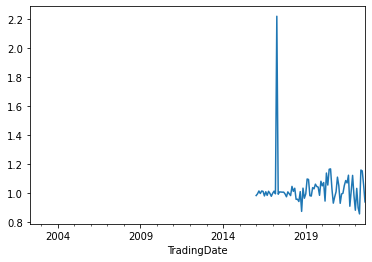

In [91]:
mixed_return[1387].plot()

In [92]:
symbol_ = 1387
mixed_return[symbol_].loc[mixed_return[symbol_].idxmax() - pd.offsets.MonthEnd(8): mixed_return[symbol_].idxmax() + pd.offsets.MonthEnd(2)]

TradingDate
2016-08    1.009063
2016-09    0.984032
2016-10    1.012170
2016-11    0.997996
2016-12    0.977912
2017-01    0.998973
2017-02    1.013361
2017-03    0.994929
2017-04    2.217125
2017-05    0.992184
2017-06    1.007878
Freq: M, Name: 1387, dtype: float64

In [93]:
mixed_return[symbol_].mean()

1.0297864012013225

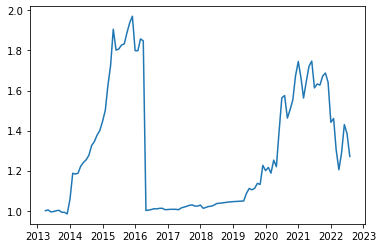

In [95]:
plt.plot(full_nav_month[full_nav_month.Symbol == 30].sort_values('EndDate').EndDate.astype(np.datetime64), full_nav_month[full_nav_month.Symbol == 30].sort_values('EndDate').NAV, )

## II.Select

月末等权重买入一种分类中所有基金

持有一个月，按月滚动调整

**?等金额权重/等份额权重**

In [56]:

# ! S_DQ_ADJCLOSE
stock_avg_change = full.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='S_DQ_CLOSE').pct_change()\
    .apply(lambda date: date.sum()/pd.notnull(date).sum() if date.sum() != 0 else None, axis=1)\
        .loc['2002-1-1':'2022-9-22']

stock_return = (stock_avg_change + 1).cumprod()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

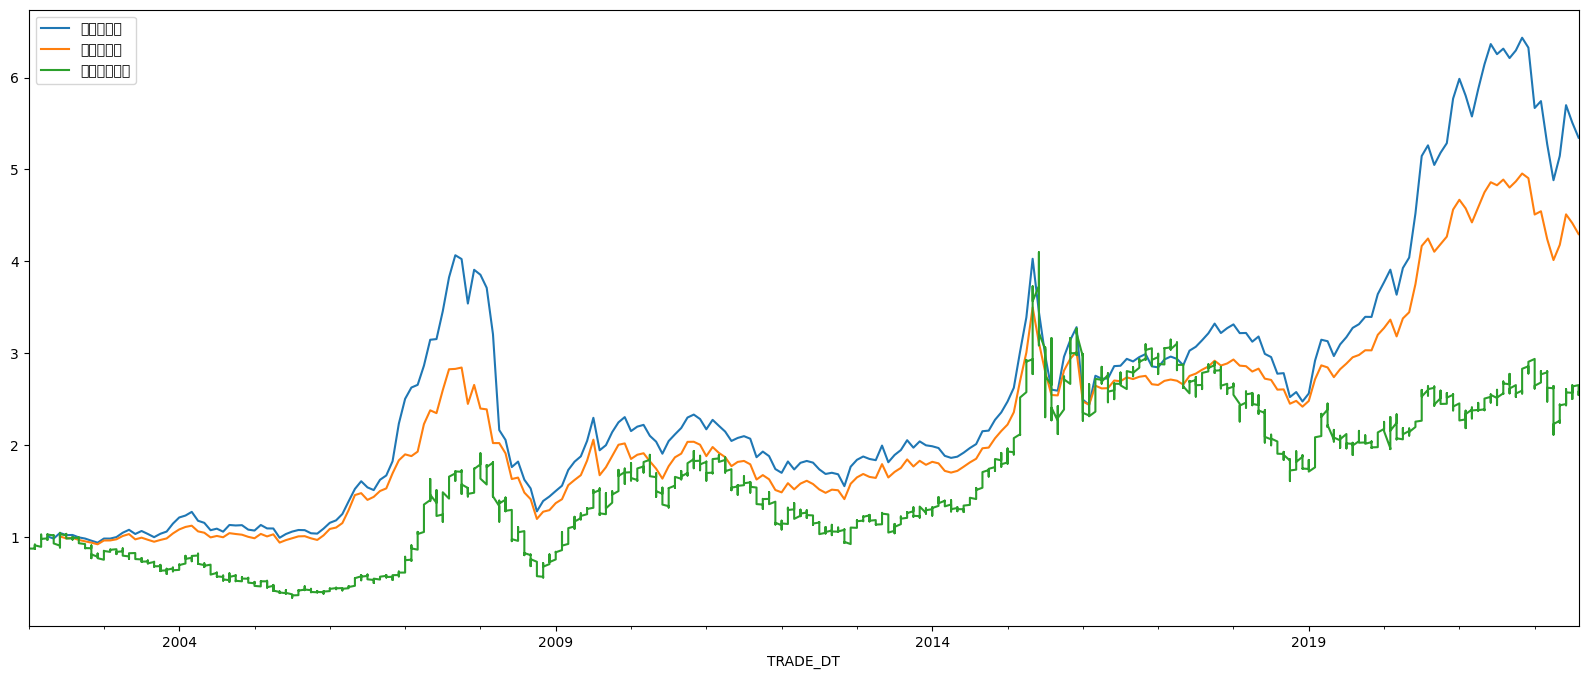

In [57]:
# 等份额权重
# remove all null month
# TODO, probable cause: funds listed before 2022-04 did not meet other requirements

plt.figure(figsize=(20,8))
stock_r_t = r_t_real_[np.intersect1d(stock_fund, r_t_real_.columns)]
stock_r_t_ = stock_r_t[~ pd.isnull(stock_r_t).all(axis=1)]
stock_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='股票型基金')
mixed_r_t = r_t_real_[np.intersect1d(integrated_fund, r_t_real_.columns)]
mixed_r_t_ = mixed_r_t[~ pd.isnull(mixed_r_t).all(axis=1)]
mixed_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='混合型基金')
stock_return.plot(label='股票市场组合')
plt.legend()